#Trabajo practico 3 Parte 2
Pinto, Nicolas \



##Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from tqdm import tqdm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from scipy.stats import uniform

##Datasets

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id= '1vAH4o97zYZ2RT8Mbgz3Be4AN2xxbA_4W'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_transaction.csv')
train_transaction = pd.read_csv('train_transaction.csv')

In [ ]:
id= '1YGDFxRvxm1wMVaL3E5GpgP2KQqun8OFj'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_identity.csv')
train_identity = pd.read_csv('train_identity.csv')

Para dividir el dataset es mejor hacerlo siguiendo un orden para evitar el time traveling, ya que no podemos agarrar datos al azar pues podriamos estar entrenando el modelo con datos que pasaron en el futuro y sacar conclusiones erroneas

In [ ]:
joineado = pd.merge(left=train_transaction, right=train_identity, left_on='TransactionID', right_on='TransactionID', how = 'left')
del(train_transaction)
del(train_identity)

In [ ]:
largo_train = int((joineado.shape[0])*0.8)
largo_validation = (joineado.shape[0]) - largo_train

In [ ]:
train_set = joineado.iloc[:int((joineado.shape[0])*0.8)].copy()

In [ ]:
validation_set = joineado.iloc[largo_train:].copy()

In [ ]:
del(joineado)

##Encoding

In [ ]:
def llenar_nan_con_promedio(df, columna, promedios_numerica):
  promedio = df[columna].mean()
  promedios_numerica[columna] = promedio
  df[columna].fillna(promedio, inplace = True)

In [ ]:
def aplicar_mean_encoding(df, columna, promedios_por_columna):
    df[columna].fillna('Desconocido', inplace = True)
    dicc = df[columna].value_counts().to_dict()
    df['aux'] = df[columna].map(dicc)
    df.loc[df['aux']<500, columna]='Otro'
    mean_encoded = df.groupby([columna])['isFraud'].mean().to_dict()
    df[columna] = df[columna].map(mean_encoded)
    train_set.drop(['aux'], axis=1, inplace = True)
    promedios_por_columna[columna] = mean_encoded


In [ ]:
def aplicar_one_hot_encoding(df, columnas):
    return pd.get_dummies(df, dummy_na=True, drop_first=True, columns=columnas)    

In [ ]:
promedios_por_columna = {}
for columna in train_set:
  if(train_set[columna].dtype==object):
    if(len(train_set[columna].value_counts()) > 5):
       aplicar_mean_encoding(train_set, columna, promedios_por_columna)

In [ ]:
columnas_one_hot = []
for columna in train_set:
  if(train_set[columna].dtype==object):
    columnas_one_hot.append(columna)
train_set = aplicar_one_hot_encoding(train_set, columnas_one_hot)

In [ ]:
promedios_numerica = {}
llenar_nan_con_promedio(train_set, 'card1', promedios_numerica)
for columna in train_set:
  if(train_set[columna].dtype == float):
    llenar_nan_con_promedio(train_set, columna, promedios_numerica)

In [ ]:
for columna in promedios_por_columna:
   promedios_numerica[columna] = promedios_por_columna[columna]['Desconocido']
   validation_set[columna] = validation_set[columna].map(promedios_por_columna)

In [ ]:
for columna in promedios_numerica:
  validation_set[columna].fillna(promedios_numerica[columna], inplace = True)

In [ ]:
validation_set = aplicar_one_hot_encoding(validation_set, columnas_one_hot)

In [ ]:
for columna in train_set:
  if columna not in validation_set:
    validation_set[columna] = 0

In [ ]:
train_set['TransactionDT']= train_set['TransactionDT'] % 86400
validation_set['TransactionDT']= validation_set['TransactionDT'] % 86400

##Dataset de train y de validacion

In [ ]:
y_train = train_set['isFraud'].copy()
train_set.drop(columns=['isFraud'],inplace=True)
train_set.drop(columns=['TransactionID'],inplace=True)
x_train = train_set

In [ ]:
y_validation = validation_set['isFraud'].copy()
validation_set.drop(columns=['isFraud'],inplace=True)
validation_set.drop(columns=['TransactionID'],inplace=True)
x_validation = validation_set

##Regresion logistica

In [ ]:
modelo = LogisticRegression(fit_intercept=True, C=0.8, max_iter=1000, random_state=1)

In [ ]:
distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2'])

In [ ]:
mejor_modelo = RandomizedSearchCV(modelo,distributions, n_iter=5, n_jobs= 1, scoring = 'roc_auc', cv=2, verbose = 100, random_state = 1)

In [ ]:
mejor_modelo.fit(x_train.values, y_train.values)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2; 1/5] START C=1.668088018810296, penalty=l2.............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/2; 1/5] END C=1.668088018810296, penalty=l2;, score=0.746 total time= 5.6min
[CV 2/2; 1/5] START C=1.668088018810296, penalty=l2.............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 1/5] END C=1.668088018810296, penalty=l2;, score=0.760 total time= 5.5min
[CV 1/2; 2/5] START C=2.8812979737686324, penalty=l2............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/2; 2/5] END C=2.8812979737686324, penalty=l2;, score=0.746 total time= 5.6min
[CV 2/2; 2/5] START C=2.8812979737686324, penalty=l2............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 2/5] END C=2.8812979737686324, penalty=l2;, score=0.759 total time= 5.6min
[CV 1/2; 3/5] START C=0.00045749926937954655, penalty=l2........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/2; 3/5] END C=0.00045749926937954655, penalty=l2;, score=0.748 total time= 5.6min
[CV 2/2; 3/5] START C=0.00045749926937954655, penalty=l2........................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 3/5] END C=0.00045749926937954655, penalty=l2;, score=0.758 total time= 5.5min
[CV 1/2; 4/5] START C=1.209330290527359, penalty=l2.............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/2; 4/5] END C=1.209330290527359, penalty=l2;, score=0.746 total time= 5.7min
[CV 2/2; 4/5] START C=1.209330290527359, penalty=l2.............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 4/5] END C=1.209330290527359, penalty=l2;, score=0.760 total time= 5.5min
[CV 1/2; 5/5] START C=0.5870235632684522, penalty=l2............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/2; 5/5] END C=0.5870235632684522, penalty=l2;, score=0.746 total time= 5.7min
[CV 2/2; 5/5] START C=0.5870235632684522, penalty=l2............................


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/2; 5/5] END C=0.5870235632684522, penalty=l2;, score=0.755 total time= 5.5min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


RandomizedSearchCV(cv=2,
                   estimator=LogisticRegression(C=0.8, max_iter=1500,
                                                random_state=1),
                   n_iter=5, n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5a75bf6a10>,
                                        'penalty': ['l2']},
                   random_state=1, scoring='roc_auc', verbose=100)

In [ ]:
import pickle
with open('model_backup', 'wb') as model_backup_file:
  pickle.dump(mejor_modelo, model_backup_file)

In [ ]:
import pickle 
with open('model_backup', 'rb') as file:
  mejor_modelo = pickle.load(file)

##Validation set

In [ ]:
x_validation = x_validation.reindex(columns=x_train.columns)

In [ ]:
print(classification_report(y_validation.values, mejor_modelo.predict(x_validation.values)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114044
           1       0.42      0.05      0.08      4064

    accuracy                           0.96    118108
   macro avg       0.69      0.52      0.53    118108
weighted avg       0.95      0.96      0.95    118108



In [ ]:
print("Mejor score de validacion:", roc_auc_score(y_validation.values, mejor_modelo.predict_proba(x_validation.values)[:,1]))

Mejor score de validacion: 0.7687619363551352


##Test set

###Datasets

In [ ]:
id= '16HGAtDL8NdWSnqE-5WThosY2q0QIoeX-'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

In [ ]:
id= '1w-hO21eHxYs8NgW_NhXZpckfGuQEL22j'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [ ]:
test_set = pd.merge(left=test_transaction, right=test_identity, left_on='TransactionID', right_on='TransactionID', how = 'left')
del(test_transaction)
del(test_identity)

###Encoding

In [ ]:
transaction_id = test_set['TransactionID']

In [ ]:
test_set.drop(columns=['TransactionID'],inplace=True)

In [ ]:
test_set['TransactionDT']= test_set['TransactionDT'] % 86400

In [ ]:
for columnas in test_set:
  test_set.rename(columns=lambda x: x.replace('id-', 'id_'), inplace = True)

In [ ]:
test_set = aplicar_one_hot_encoding(test_set, columnas_one_hot)

In [ ]:
for columna in promedios_por_columna:
   test_set[columna] = test_set[columna].map(promedios_por_columna)

In [ ]:
for columna in promedios_numerica:
  test_set[columna].fillna(promedios_numerica[columna], inplace = True)

In [ ]:
for columna in train_set:
  if columna not in test_set:
    test_set[columna] = 0

In [ ]:
test_set = test_set.reindex(columns=x_train.columns)

###Probabilidad

In [ ]:
 mejor_modelo.predict_proba(test_set.values)[:,1]

array([0.00599291, 0.02974556, 0.03172907, ..., 0.01957888, 0.01933572,
       0.11959084])

##Features mas importantes

In [ ]:
coeficientes = mejor_modelo.best_estimator_.coef_[0].copy()

In [ ]:
arr = []
for columna in train_set:
  arr.append(train_set[columna].mean())

In [ ]:
for i in range (len(arr)):
  if arr[i] != 0:
    coeficientes[i] = coeficientes[i]/arr[i]

In [ ]:
coeficientes_modulo = np.absolute(coeficientes)
max_index = (-coeficientes_modulo).argsort()[:10]

In [ ]:
features_importantes_reducido = []
scores = []
for i in max_index:
  features_importantes_reducido.append(x_train.columns[i])
  scores.append(coeficientes[i])

features_importantes_con_scores_reducido = pd.DataFrame(scores, features_importantes_reducido)
features_importantes_con_scores_reducido.reset_index(inplace = True)
features_importantes_con_scores_reducido.rename(columns={'index': 'feature', 0: 'score'},inplace = True)

In [ ]:
features_importantes_con_scores_reducido["Color"] = np.where(features_importantes_con_scores_reducido["score"]<0, 'blue', 'orange')
features_importantes_con_scores_reducido["Signo"] = np.where(features_importantes_con_scores_reducido['Color'] == 'blue', 'Negativo', 'Positivo')
features_importantes_con_scores_reducido['score'] = abs(features_importantes_con_scores_reducido['score'])
features_importantes_con_scores_reducido

,feature,score,Color,Signo
0,id_27_NotFound,0.001449,blue,Negativo
1,V101,0.001216,orange,Positivo
2,V103,0.000881,orange,Positivo
3,V232,0.000866,orange,Positivo
4,V40,0.000865,orange,Positivo
5,V79,0.000838,orange,Positivo
6,V52,0.000837,orange,Positivo
7,V233,0.000825,orange,Positivo
8,V81,0.000821,orange,Positivo
9,V18,0.000820,orange,Positivo


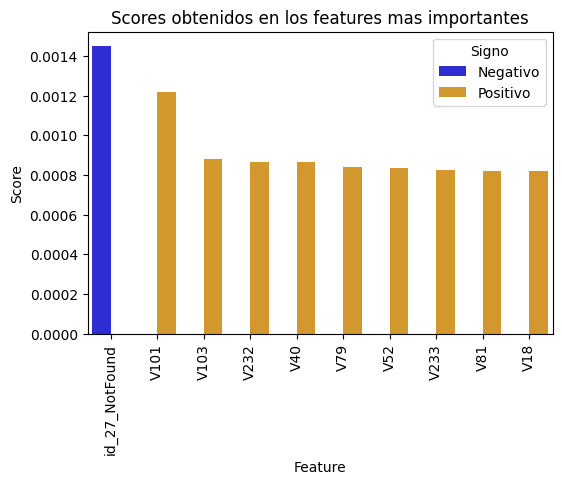

In [ ]:
plt.figure(dpi = 100)
barplot = sns.barplot(x=features_importantes_con_scores_reducido['feature'], y = features_importantes_con_scores_reducido['score'],
                      data = features_importantes_con_scores_reducido, palette=features_importantes_con_scores_reducido['Color'], saturation = .65, hue='Signo')
barplot.set(xlabel='Feature', ylabel='Score', title = 'Scores obtenidos en los features mas importantes')
plt.xticks(rotation = 90)

plt.show()

##Otros features importantes

In [ ]:
coeficientes_modulo = np.absolute(coeficientes)
max_index = (-coeficientes_modulo).argsort()[:80]

In [ ]:
features_importantes = []
scores = []
for i in max_index:
  features_importantes.append(x_train.columns[i])
  scores.append(coeficientes[i])
features_importantes_con_scores = pd.DataFrame(scores, features_importantes)

In [ ]:
features_importantes_con_scores.reset_index(inplace = True)
features_importantes_con_scores.rename(columns={'index': 'feature', 0: 'score'},inplace = True)

In [ ]:
features_importantes_con_scores['feature'].to_list()

['id_27_NotFound',
 'V101',
 'V103',
 'V232',
 'V40',
 'V79',
 'V52',
 'V233',
 'V81',
 'V18',
 'M4_M2',
 'V17',
 'V281',
 'C3',
 'V27',
 'V28',
 'V95',
 'V33',
 'V34',
 'V231',
 'V80',
 'V89',
 'V16',
 'V15',
 'V39',
 'V74',
 'V51',
 'V58',
 'V94',
 'DeviceType_mobile',
 'V93',
 'V85',
 'V43',
 'V73',
 'V68',
 'V22',
 'V177',
 'V57',
 'V21',
 'V92',
 'V72',
 'V32',
 'V31',
 'id_15_Unknown',
 'V60',
 'V102',
 'card6_debit or credit',
 'V84',
 'V219',
 'card4_discover',
 'V42',
 'V64',
 'V179',
 'V71',
 'V59',
 'V217',
 'V63',
 'V239',
 'V218',
 'V311',
 'V50',
 'V303',
 'V301',
 'V147',
 'V97',
 'V178',
 'id_04',
 'V106',
 'V237',
 'V185',
 'V236',
 'V304',
 'card6_credit',
 'V167',
 'V104',
 'V299',
 'V238',
 'id_37_T',
 'V235',
 'V302']

##Score de la competencia

In [ ]:
predicciones_fraude = pd.DataFrame()
predicciones_fraude['isFraud'] = mejor_modelo.predict_proba(test_set.values)[:,1]
predicciones_fraude['TransactionID']= transaction_id.values
predicciones_fraude.to_csv('predicciones_fraude.csv', index=False)

<img src= "https://drive.google.com/uc?id=1HJMXQucSOX6H89IBoxAyNxlL8u_OVF-s" width="100%">
